In [24]:
import tensorflow as tf

In [25]:
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [45]:
import pandas as pd
import os

df=pd.read_csv(os.path.join(os.getcwd(), 'eurousd.csv'))
df.head()

,date,time,open,high,low,close,volume
0,21/10/2002,01:05:00,0.97320,0.97325,0.97280,0.97285,0
1,21/10/2002,01:10:00,0.97300,0.97320,0.97300,0.97320,0
2,21/10/2002,01:15:00,0.97320,0.97320,0.97295,0.97310,0
3,21/10/2002,01:20:00,0.97315,0.97340,0.97270,0.97270,0
4,21/10/2002,01:25:00,0.97280,0.97295,0.97260,0.97260,0


In [27]:
df['PrevClose'] = df['close'].shift(1)
df.head()

,time,price,PrevClose
0,2019-01-01 22:00:00+00:00,1.14658,NaN
1,2019-01-01 22:05:00+00:00,1.14635,1.14658
2,2019-01-01 22:10:00+00:00,1.14632,1.14635
3,2019-01-01 22:15:00+00:00,1.14632,1.14632
4,2019-01-01 22:20:00+00:00,1.14653,1.14632


In [28]:
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']
df['mom']=df['close'].rolling(3).mean()
df.head()

,time,price,PrevClose,Return,mom
0,2019-01-01 22:00:00+00:00,1.14658,NaN,NaN,NaN
1,2019-01-01 22:05:00+00:00,1.14635,1.14658,-0.000201,NaN
2,2019-01-01 22:10:00+00:00,1.14632,1.14635,-0.000026,1.146417
3,2019-01-01 22:15:00+00:00,1.14632,1.14632,0.000000,1.146330
4,2019-01-01 22:20:00+00:00,1.14653,1.14632,0.000183,1.146390


In [29]:
input_data = df[['close', 'mom']][2:]
targets = df['Return'].values

In [30]:
T = 10
D = input_data.shape[1]
N = len(input_data) - T
print(D)

2


In [31]:
Ntrain=int(len(input_data)*0.8)
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [32]:
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T]>0)

In [33]:
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T]>0 )

In [34]:
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(learning_rate=0.001),
  metrics=['accuracy'],
)

In [35]:
#es = EarlyStopping(patience=20, restore_best_weights=True)
#callbacks=[es],
history = model.fit(X_train, Y_train,
          validation_split=0.2,
          batch_size=32,
          epochs=40,

          verbose=1)

Epoch 1/50
1475/1475 [==============================] - 21s 13ms/step - loss: 0.6933 - accuracy: 0.5051 - val_loss: 0.6922 - val_accuracy: 0.5111
Epoch 2/50
1475/1475 [==============================] - 19s 13ms/step - loss: 0.6902 - accuracy: 0.5360 - val_loss: 0.6887 - val_accuracy: 0.5673
Epoch 3/50
1475/1475 [==============================] - 19s 13ms/step - loss: 0.6138 - accuracy: 0.6713 - val_loss: 1.9689 - val_accuracy: 0.5434
Epoch 4/50
1475/1475 [==============================] - 19s 13ms/step - loss: 0.3552 - accuracy: 0.8640 - val_loss: 4.1426 - val_accuracy: 0.6437
Epoch 5/50
1475/1475 [==============================] - 18s 12ms/step - loss: 0.2517 - accuracy: 0.9033 - val_loss: 5.0026 - val_accuracy: 0.6688
Epoch 6/50
1475/1475 [==============================] - 18s 13ms/step - loss: 0.2068 - accuracy: 0.9207 - val_loss: 5.6703 - val_accuracy: 0.6638
Epoch 7/50
1475/1475 [==============================] - 18s 12ms/step - loss: 0.1794 - accuracy: 0.9309 - val_loss: 6.2954 -

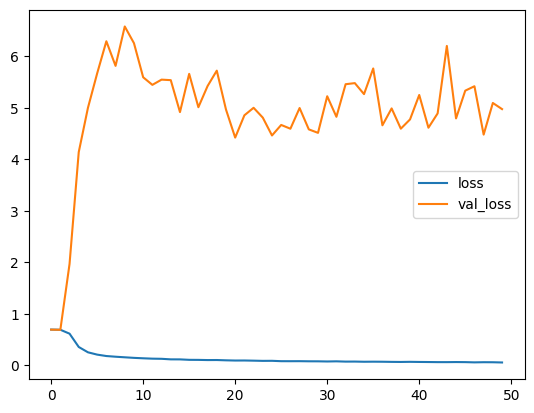

In [36]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

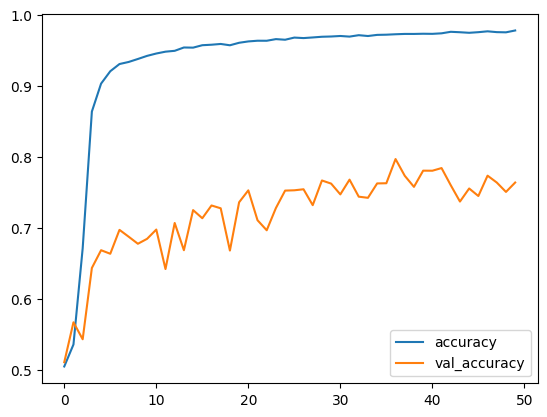

In [37]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [38]:
pred=model.predict(X_test)


461/461 [==============================] - 2s 4ms/step


In [39]:
lstm2=model.evaluate(X_test, Y_test)

461/461 [==============================] - 2s 5ms/step - loss: 0.2117 - accuracy: 0.9279


(array([6748.,  324.,  149.,  149.,  141.,   96.,   95.,  123.,  118.,
          85.,   65.,   49.,   58.,   59.,   44.,   46.,   43.,   24.,
          38.,   33.,   32.,   30.,   25.,   27.,   39.,   22.,   24.,
          21.,   23.,   34.,   29.,   32.,   30.,   32.,   33.,   33.,
          33.,   42.,   42.,   50.,   64.,   69.,   62.,   88.,   73.,
          90.,  124.,  138.,  195., 4711.]),
 array([6.51287059e-28, 1.99999996e-02, 3.99999991e-02, 5.99999987e-02,
        7.99999982e-02, 1.00000001e-01, 1.19999997e-01, 1.40000001e-01,
        1.59999996e-01, 1.80000007e-01, 2.00000003e-01, 2.19999999e-01,
        2.39999995e-01, 2.59999990e-01, 2.80000001e-01, 3.00000012e-01,
        3.19999993e-01, 3.40000004e-01, 3.60000014e-01, 3.79999995e-01,
        4.00000006e-01, 4.19999987e-01, 4.39999998e-01, 4.60000008e-01,
        4.79999989e-01, 5.00000000e-01, 5.19999981e-01, 5.40000021e-01,
        5.60000002e-01, 5.79999983e-01, 6.00000024e-01, 6.20000005e-01,
        6.39999986e-01, 

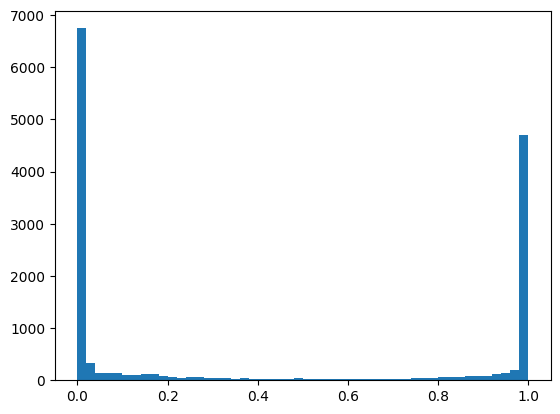

In [40]:
plt.hist(pred , bins=50)